In [58]:
from model import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import *
import gmaps
import gmaps.datasets

In [2]:
df_commute = pd.read_csv('data/commute_data.csv')
df_tracts = pd.read_csv('data/census_tracts_2010.csv')
df_tracts = df_tracts.rename(columns=lambda x: x.strip())

# Merge on OFIPS = GEOID (federal representation of census tract ID)
df_merged = df_commute.merge(df_tracts, how='inner', left_on='OFIPS', right_on='GEOID')
df_merged = df_merged.merge(df_tracts, how='inner', left_on='DFIPS', right_on='GEOID', suffixes = ('_O','_D'))

In [3]:
df_bayarea = limit_area(df_merged, minlat=35.959793, maxlat=38.419866, minlong=-123.355416, maxlong=-120.609292)

In [61]:
df_state = limit_area(df_merged, state='NY', maxlat=41)

In [70]:
df_nyc = limit_area(df_merged, minlat=40.5, maxlat=41, minlong=-74.25, maxlong=-73.75)

In [5]:
df_distance_matrix = create_distance_matrix(df_bayarea, method='absolute')

In [6]:
linkage_method = 'complete'
Z = linkage(df_distance_matrix, linkage_method)

In [9]:
Z_df = pd.DataFrame(Z).astype('int')
Z_df

,0,1,2,3
0,358,760,2343,2
1,357,1956,3046,3
2,1003,1957,3518,4
3,1793,1958,4104,5
4,1456,1959,5082,6
5,776,798,5463,2
6,362,364,5716,2
7,575,647,5746,2
8,131,1960,5986,7
9,704,714,6187,2


In [168]:

k = 10
df_results = pd.DataFrame(index = df_distance_matrix.columns, data=fcluster(Z,k,criterion='maxclust'))
df_results = df_results.rename(columns={0: 'cluster_id'})
df_results = df_results.merge(df_tracts, left_index=True, right_on='GEOID')

df_results_2 = df_results.copy().reset_index()
step_0 = df_results_2.merge(Z_df, how='left', left_index=True, right_on=0).set_index(0)
step_1 = df_results_2.merge(Z_df, how='left', left_index=True, right_on=1).set_index(1)
# step_0 = step_0[3].fillna(step_1[3])
# step_0 = step_0[2].fillna(step_1[2])
df_results_2['hc_level']=step_0[3].fillna(step_1[3])
df_results_2['alpha'] = 0.5/df_results_2['hc_level']

In [169]:
df_results_2.describe()

,index,cluster_id,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,hc_level,alpha
count,1956.000000,1956.000000,1.956000e+03,1956.000000,1956.000000,1.956000e+03,1.956000e+03,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000,1956.000000
mean,8204.943252,6.129346,6.057529e+09,4635.040900,1758.050613,2.018484e+07,7.377669e+05,7.793417,0.284854,37.653444,-121.974163,3.571063,0.206381
std,2983.846236,1.855699,3.565229e+07,1859.286473,704.972604,1.313833e+08,5.061828e+06,50.727396,1.954372,0.398292,0.438012,7.357274,0.066484
min,3560.000000,1.000000,6.001400e+09,38.000000,2.000000,5.656400e+04,0.000000e+00,0.022000,0.000000,35.966858,-122.985811,2.000000,0.002381
25%,4117.750000,4.000000,6.013349e+09,3371.000000,1272.750000,1.012301e+06,0.000000e+00,0.391000,0.000000,37.398627,-122.282477,2.000000,0.166667
50%,10011.500000,6.000000,6.075038e+09,4424.500000,1681.000000,1.738810e+06,0.000000e+00,0.671000,0.000000,37.719625,-122.039859,2.000000,0.250000
75%,10649.250000,7.000000,6.085505e+09,5669.750000,2187.500000,4.163416e+06,2.196000e+03,1.607500,0.001000,37.910766,-121.815560,3.000000,0.250000
max,11261.000000,10.000000,6.099004e+09,20177.000000,8255.000000,3.667173e+09,1.238387e+08,1415.903000,47.814000,38.419817,-120.611118,210.000000,0.250000


In [170]:
cluster_order = list(df_results_2.groupby('cluster_id').count().sort_values('GEOID', ascending=False).index)

In [171]:
from matplotlib import cm
colors = []
for i, val in enumerate(cluster_order):
    (r, g, b, a) = cm.Dark2(i%8)
    colors.append([val,r, g, b])

#colors = np.array(colors)
colors = pd.DataFrame(colors, columns=['cluster_id','r','g','b'])

In [172]:
#color_array = np.array(df_results_2[['r', 'g', 'b', 'alpha']])

In [173]:
df_results_2 = df_results_2.merge(colors, on='cluster_id')

In [174]:
color_array = []
for i, row in df_results_2.iterrows():
    r, g, b, a = row['r'], row['g'], row['b'], row['alpha']
    color_array.append([r, g, b, a])

In [175]:
#def rgba(row):
#    row['rgba'] =list([row['color'][0],row['color'][1],row['color'][2],row['alpha']])
#    return row
#df_color = df_results_2.apply(rgba,axis=1)

In [176]:
#rgba_color = np.array(df_color['rgba'].values)

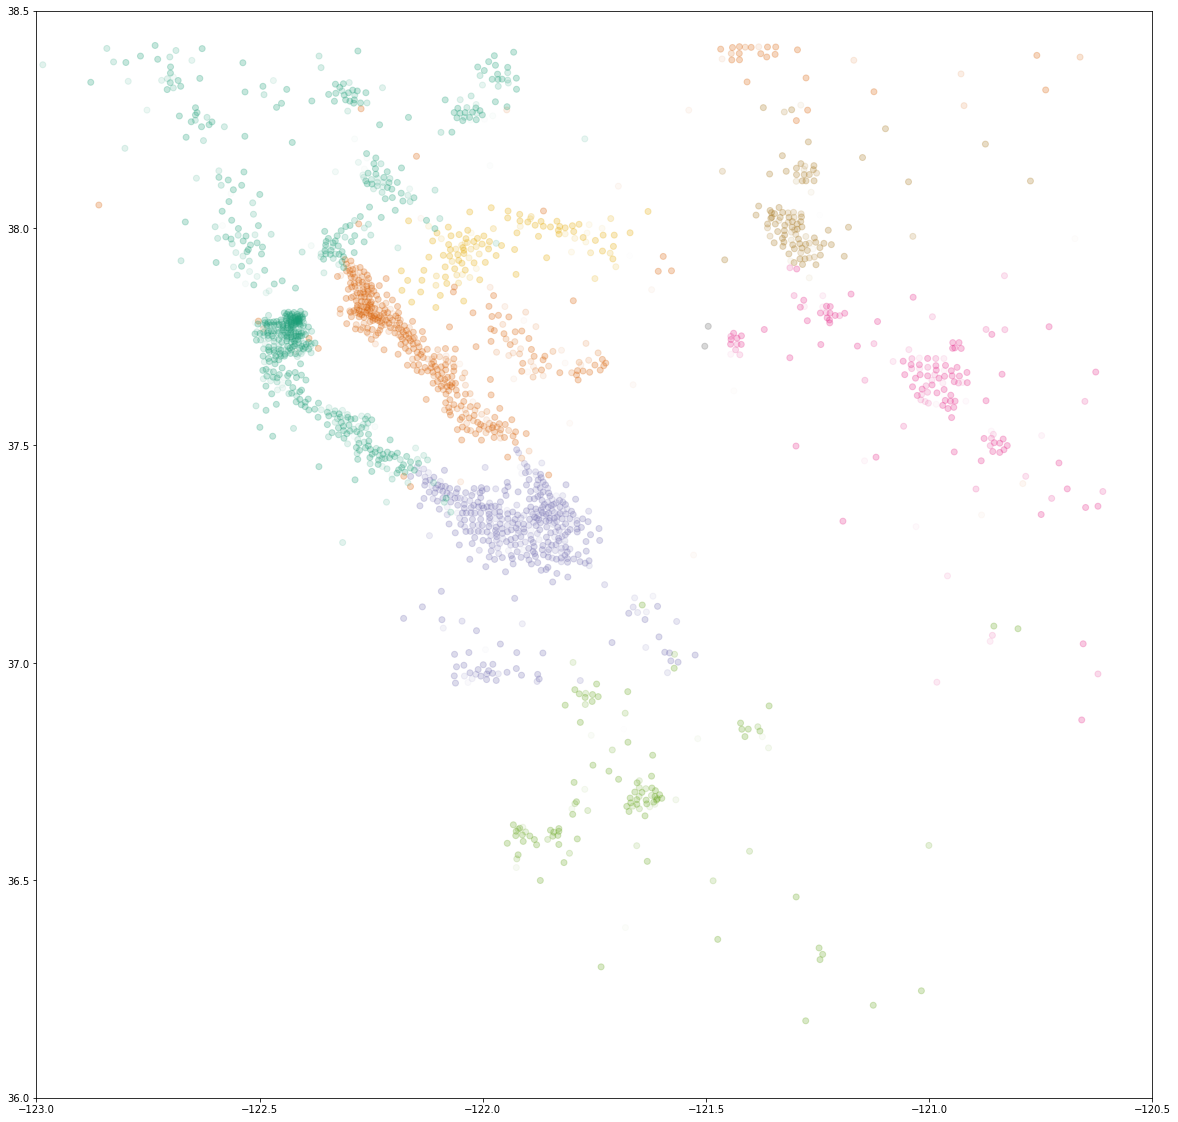

In [177]:
plt.figure(figsize=(20,20))
plt.scatter(df_color['INTPTLONG'],df_color['INTPTLAT'], color=color_array)
plt.ylim(36,38.5)
plt.xlim(-123,-120.5)
plt.show()

In [167]:
# Use google maps api
gmaps.configure(api_key=api_key) # Fill in with your API key

#Set up your map
fig = gmaps.figure()
colors = list(df_results['color'].values)
locations = list(zip(df_results['INTPTLAT'],df_results['INTPTLONG']))
symbols = gmaps.symbol_layer(
        locations,
        fill_color=colors,
        stroke_color=colors,
        scale=2)
fig.add_layer(symbols)
fig

NameError: name 'api_key' is not defined